# EFD latency characterization

This notebook shows how to get data from the InfluxDB API to characterize the total latency for a message from the time it is sent by SAL to the time it is written to InfluxDB.

In [31]:
%%capture packages
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install requests

In [32]:
import requests
import matplotlib.pyplot as plt
import pandas as pd

## InfluxDB URL and database to read from

In [33]:
INFLUXDB_API_URL = "https://influxdb-summit-efd.lsst.codes"
INFLUXDB_DATABASE = "efd"

In [34]:
import getpass
USERNAME = "saluser"
PASSWORD = getpass.getpass(prompt='Password for user `{}`: '.format(USERNAME))

Password for user `saluser`: ········


## Retrieving timestamps for a given topic
The following timestamps are available (the order reflects the actual message flow through the system) 

- **private_sndStamp**: TAI timestamp in seconds added by SAL when the message was created
- **private_kafkaStamp**: TAI timestamp in seconds added by the SAL Kafka Producer right before it is sent to the EFD
- **time**: UTC timestamp in millisecons when the message is written to InfluxDB.


In [35]:
def get_timestamps(topic, past='1h'):
    
    query = 'SELECT "private_sndStamp", "private_kafkaStamp" FROM "{}\"."autogen"."{}" where time > now()-{}'
    params={'q': query.format(INFLUXDB_DATABASE, topic, past), 'epoch': 'ms', 'chunked': '200000', 'u': USERNAME, 'p': PASSWORD}
    
    r = requests.post(url=INFLUXDB_API_URL + "/query", params=params)
    
    return r.json()

In [36]:
data = get_timestamps("lsst.sal.MTM1M3.forceActuatorData")['results'][0]['series'][0]
df = pd.DataFrame.from_records(data['values'], columns=data['columns'])
df.head()

,time,private_sndStamp,private_kafkaStamp
0,1582749075009,1.582749e+09,1.582749e+09
1,1582749075085,1.582749e+09,1.582749e+09
2,1582749075183,1.582749e+09,1.582749e+09
3,1582749075284,1.582749e+09,1.582749e+09
4,1582749075382,1.582749e+09,1.582749e+09


## Latency and time in seconds

In [51]:

# Latency between SAL Kafka Producer and SAL
df['latency1'] = (df['private_kafkaStamp'] - df['private_sndStamp'])

# Latency between InfluxDB and SAL Kafka Producer, take into account the difference between UTC and TAI
df['latency2'] = df['time']/1000 - df['private_kafkaStamp'] + 37

# Total latency, take into account the differece between UTC and TAI
df['latency_total'] = df['time']/1000 - df['private_sndStamp'] + 37


df['time_seconds'] = (df['time']-df['time'][0])/1000

## Latency  characterization

Text(50, 0.2934532070159912, 'Median=0.0055s 99% percentile=0.03s')

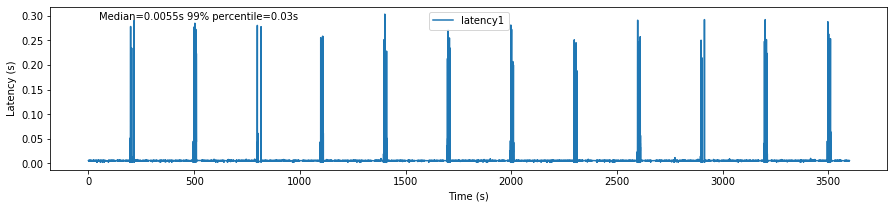

In [52]:
median = df.latency1.median()
quantile99 = df.latency1.quantile(.99)

p = df.plot(x='time_seconds', y='latency1', figsize=(15,3))
p.set_xlabel("Time (s)")
p.set_ylabel("Latency (s)")
p.text(50,df.latency1.max()-0.01,"Median={:.4f}s 99% percentile={:.2f}s".format(median, quantile99))

Text(50, 19.735854148864746, 'Median=0.0174s 99% percentile=13.98s')

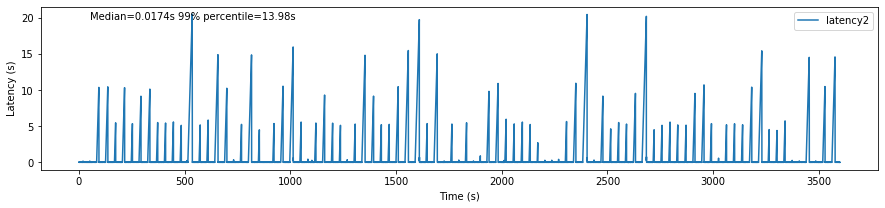

In [53]:
median = df.latency2.median()
quantile99 = df.latency2.quantile(.99)

p = df.plot(x='time_seconds', y='latency2', figsize=(15,3))
p.set_xlabel("Time (s)")
p.set_ylabel("Latency (s)")
p.text(50,df.latency2.max()-0.75,"Median={:.4f}s 99% percentile={:.2f}s".format(median, quantile99))

Text(50, 19.74165439605713, 'Median=0.0231s 99% percentile=13.99s')

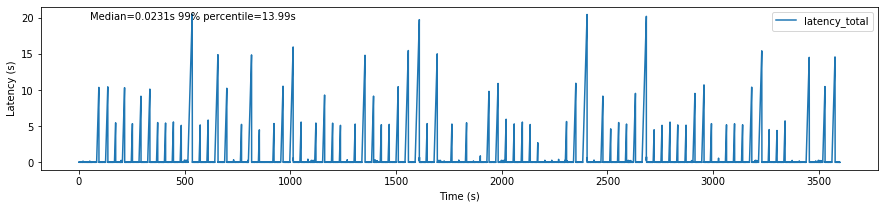

In [54]:
median = df.latency_total.median()
quantile99 = df.latency_total.quantile(.99)

p = df.plot(x='time_seconds', y='latency_total', figsize=(15,3))
p.set_xlabel("Time (s)")
p.set_ylabel("Latency (s)")
p.text(50,df.latency_total.max()-0.75,"Median={:.4f}s 99% percentile={:.2f}s".format(median, quantile99))